# Visualize agent performance
In order to run this notebook, evaluate an agent on an environment (see [[../baselines/baseline_agent.py]]).

In [1]:
import json
from dataclasses import dataclass
from pathlib import Path
from typing import List

from matplotlib import gridspec
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
@dataclass
class AgentMetrics:
    label: str
    returns: List[float]
    survival_duration: List[int]


def visualize_agent_survival(datasets: List[AgentMetrics]):
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # Define figure with a GridSpec: widths [1, 2, 1]
    fig = plt.figure(figsize=(20, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 1], figure=fig)

    axes = [fig.add_subplot(gs[i]) for i in range(3)]

    max_survival_duration = max(max(data.survival_duration) for data in datasets)

    # --- Strip Plot ---
    records = []
    for data in datasets:
        records.extend([{"Agent": data.label, "Survival Duration": d}
                        for d in data.survival_duration])
    df = pd.DataFrame(records)

    sns.stripplot(
        data=df,
        y="Survival Duration",
        x="Agent",
        hue="Agent",
        ax=axes[0],
        dodge=True,
        alpha=0.6
    )

    axes[0].set_title("Survival Duration (Strip Plot)")
    axes[0].set_ylabel("Time Steps")
    axes[0].set_xlabel("Agent")

    # --- KDE Plot ---
    for data in datasets:
        sns.kdeplot(
            data.survival_duration,
            ax=axes[1],
            label=data.label,
            bw_adjust=0.5
        )

    axes[1].set_xlim(0, max_survival_duration)
    axes[1].set_title("Survival Duration Distribution (KDE) per Agent")
    axes[1].set_xlabel("Time Steps")
    axes[1].set_ylabel("Density")
    axes[1].legend(title="Agent")

    # --- Boxplot ---
    sns.boxplot(
        data=df,
        x="Agent",
        y="Survival Duration",
        hue="Agent",
        ax=axes[2],
        palette="muted",
        legend=False
    )

    axes[2].set_title("Survival Duration Boxplot per Agent")
    axes[2].set_xlabel("Agent")
    axes[2].set_ylabel("Time Steps")

    plt.tight_layout()
    plt.show()

    for data in datasets:
        print(f"Average survival ratios {data.label}: {sum(data.survival_duration) / len(data.survival_duration)}")



def visualize_agent_survival_return_relationship(datasets: List[AgentMetrics]):
    plt.figure(figsize=(7.5, 5))
    for data in datasets:
        sns.scatterplot(
            x=data.survival_duration,
            y=data.returns,
            label=data.label
        )
    plt.title("Returns vs Survival Duration")
    plt.xlabel("Survival Duration (Time Steps)")
    plt.ylabel("Return")
    plt.legend()
    plt.show()


def get_evaluation_metrics(path, agent_name: str) -> AgentMetrics:
    survival_duration = []
    returns = []
    for folder in path.iterdir():
        if folder.is_dir():
            with Path.joinpath(folder, "episode_meta.json").open() as f:
                episode_metadata = json.load(f)
                survival_duration.append(episode_metadata["nb_timestep_played"])
                returns.append(episode_metadata["cumulative_reward"])

    return AgentMetrics(agent_name, returns, survival_duration)


# Compare agent survival on test sets

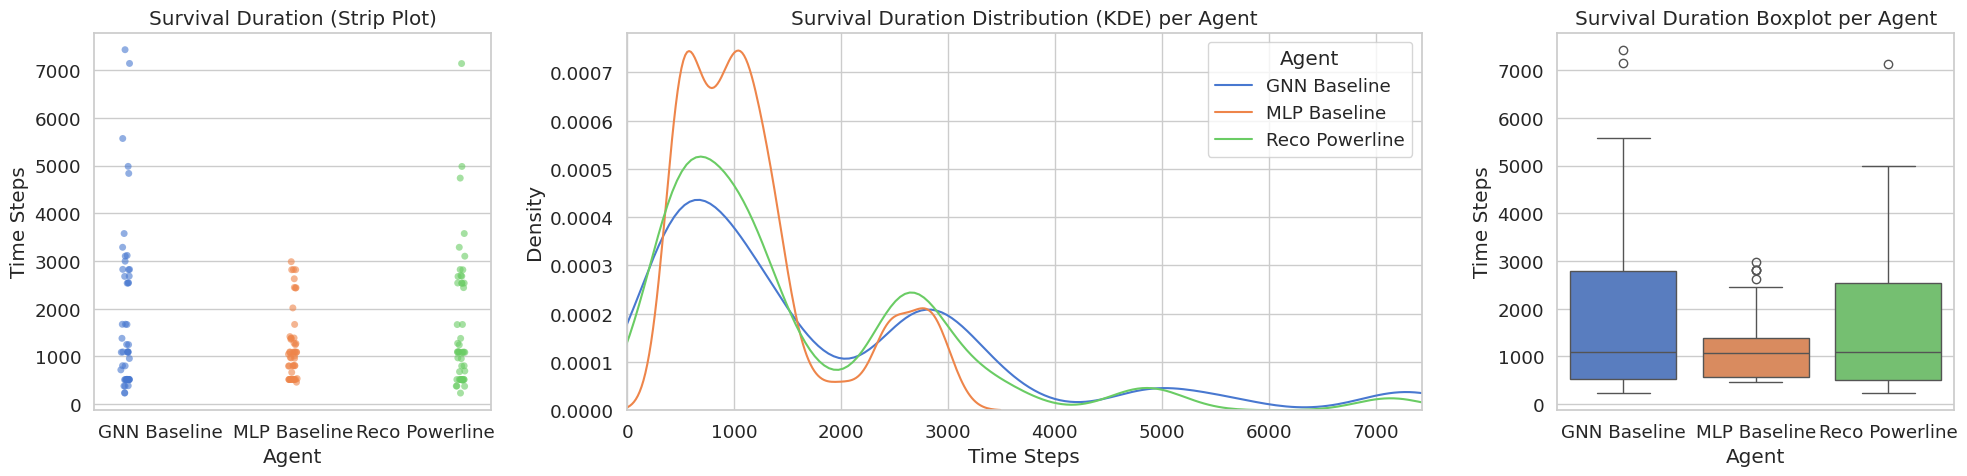

Average survival ratios GNN Baseline: 1871.08
Average survival ratios MLP Baseline: 1212.3
Average survival ratios Reco Powerline: 1620.6


In [3]:
gnn_metrics = get_evaluation_metrics(Path("../data/evaluations/stable-baselines/dqn-gnn_uc3_agent/test"), "GNN Baseline")
mlp_metrics = get_evaluation_metrics(Path("../data/evaluations/stable-baselines/dqn-mlp_uc3_agent/test"), "MLP Baseline")
reco_metrics = get_evaluation_metrics(Path("../data/evaluations/heuristic_agents/reco_powerline_agent/test"), "Reco Powerline")
visualize_agent_survival([gnn_metrics, mlp_metrics, reco_metrics])

# Compare agent survival on training sets

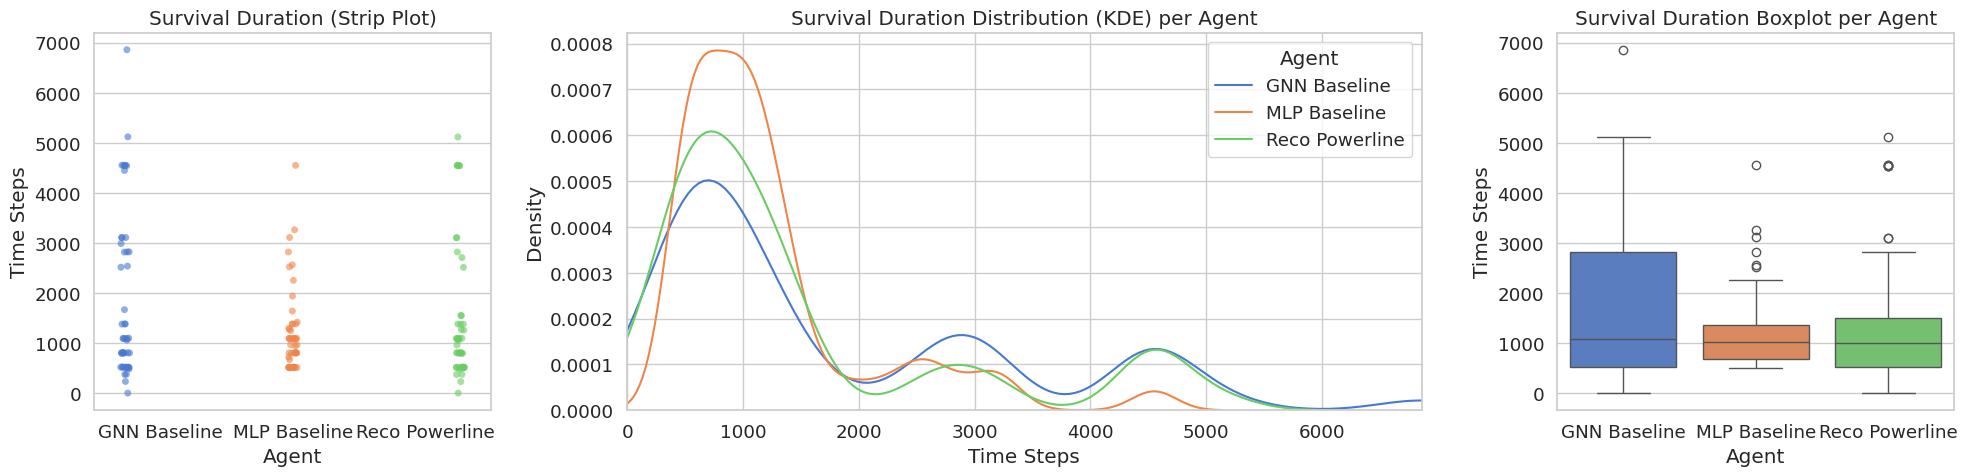

Average survival ratios GNN Baseline: 1809.02
Average survival ratios MLP Baseline: 1215.62
Average survival ratios Reco Powerline: 1480.74


In [4]:
gnn_metrics_train = get_evaluation_metrics(Path("../data/evaluations/stable-baselines/dqn-gnn_uc3_agent/train"), "GNN Baseline")
mlp_metrics_train = get_evaluation_metrics(Path("../data/evaluations/stable-baselines/dqn-mlp_uc3_agent/train"), "MLP Baseline")
reco_metrics_train = get_evaluation_metrics(Path("../data/evaluations/heuristic_agents/reco_powerline_agent/train"), "Reco Powerline")
visualize_agent_survival([gnn_metrics_train, mlp_metrics_train, reco_metrics_train])

# Check Topology Policy

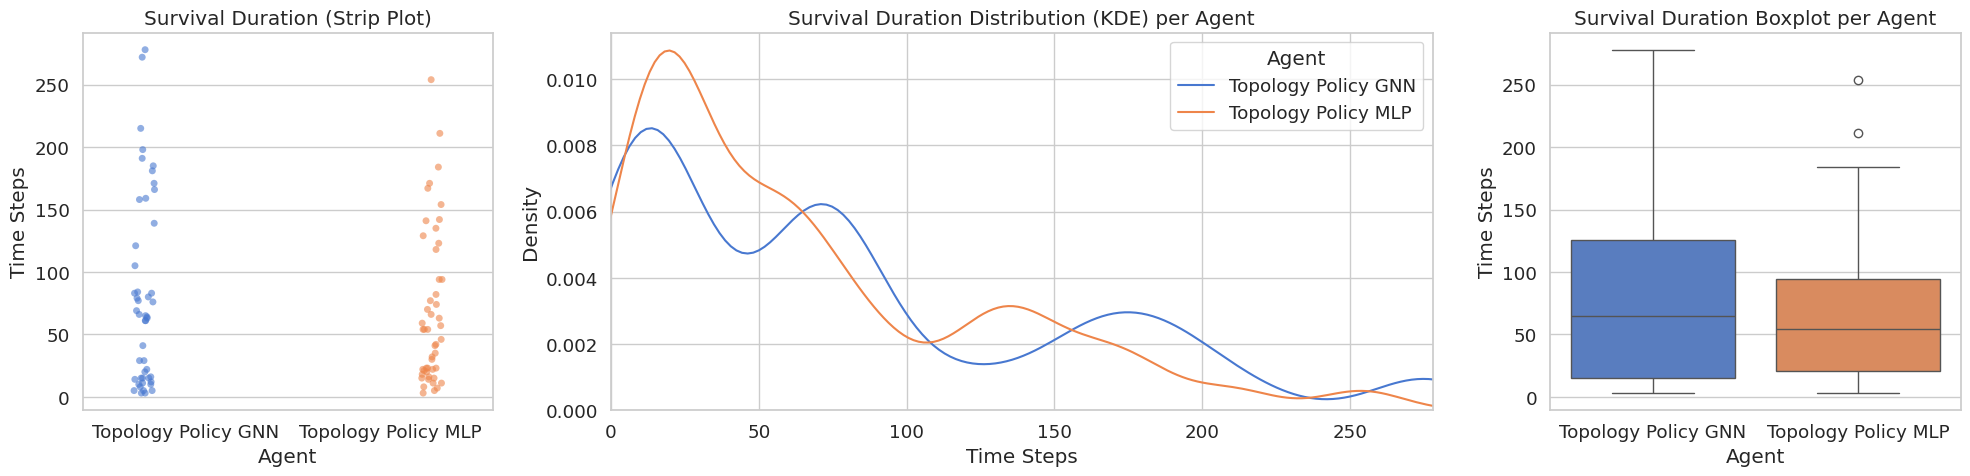

Average survival ratios Topology Policy GNN: 79.95833333333333
Average survival ratios Topology Policy MLP: 67.95918367346938


In [7]:
mlp_topo_metrics = get_evaluation_metrics(Path("../data/evaluations/stable-baselines/dqn-mlp_uc3_topology_policy"), "Topology Policy MLP")
gnn_topo_metrics = get_evaluation_metrics(Path("../data/evaluations/stable-baselines/dqn-gnn_uc3_topology_policy"), "Topology Policy GNN")
visualize_agent_survival([gnn_topo_metrics, mlp_topo_metrics])

# Relation between reward and survival duration

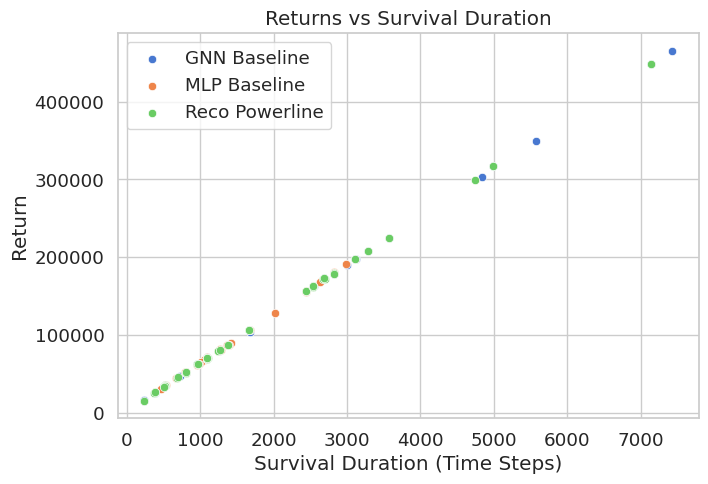

In [6]:
visualize_agent_survival_return_relationship([gnn_metrics, mlp_metrics, reco_metrics])